# Проект: HR-аналитика - Прогнозирование удовлетворенности и увольнения сотрудников

## Описание проекта
**Цель исследования**

Разработать модели машинного обучения для предсказания:

1. Уровня удовлетворенности сотрудника работой.
2. Вероятности увольнения сотрудника.

**Задачи исследования**

1. Провести анализ и предобработку данных.
2. Выявить основные факторы, влияющие на удовлетворенность и увольнение сотрудников.
3. Обучить и оценить модели прогнозирования.
4. Сделать выводы и предложить рекомендации.

**Исходные данные**

Компания предоставила следующие данные:

- **id** — уникальный идентификатор сотрудника;
- **dept** — отдел, в котором работает сотрудник;
- **level** — уровень занимаемой должности;
- **workload** — уровень загруженности сотрудника;
- **employment_years** — длительность работы в компании (в годах);
- **last_year_promo** — было ли повышение за последний год;
- **last_year_violations** — наличие нарушений трудового договора за последний год;
- **supervisor_evaluation** — оценка работы сотрудника руководителем;
- **salary** — ежемесячная зарплата;
- **job_satisfaction_rate** — уровень удовлетворенности (целевой признак);
- **quit** — увольнение сотрудника (целевой признак).

## Загрузка данных

In [1]:
# установим библиотеку phik
!pip install phik -q 

# обновим библиотеку scikit-learn
!pip install scikit-learn --upgrade -q

# установим библиотеку shap
!pip install shap -q

In [2]:
# импортируем библиотеку pandas для работы с таблицами
import pandas as pd

# импортируем библиотеку matplotlib для создания фигур
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 50

# импортируем stats из библиотеки scipy для проверки гипотез
from scipy import stats as st

# импортируем библиотеку seaborn
import seaborn as sns

# импортируем библиотеку numpy
import numpy as np

# импортируем библиотеку shap
import shap

import warnings
# cкрываем предупреждения типа UserWarning
warnings.filterwarnings('ignore', category=UserWarning)

from matplotlib.cbook import boxplot_stats

# импортируем функцию
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# импортируем классы для кодирования данных из библиотеки sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder  

# импортируем классы для масштабирования данных из библиотеки sklearn 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

# импортируем функции расчёта метрик  из библиотеки sklearn
from sklearn.metrics import (
    roc_auc_score,
    make_scorer,
)

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.dummy import DummyRegressor

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# прочитаем csv-файлы и сохраним в датафреймы
train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_input = pd.read_csv('/datasets/test_features.csv')
test_job = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [5]:
# выведем первые 5 строк таблиц на экран для ознакомления
display(train_job.head())
display(train_quit.head())
display(test_input.head())
display(test_job.head())
test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


##  Предобработка данных

### Обзор данных

In [6]:
# создадим функцию для обзора данных
def result(table):
    temp = table.copy() 
    list_c = table.columns
    print(temp.info())
    for col_l in list_c:
        if temp[col_l].dtype == 'object':
            print('-'* 25)
            print(col_l, temp[col_l].sort_values().unique())

In [7]:
# вызовем функцию обзора данных
result(train_job)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None
-------------------------
dept ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan]
-------------------------
level ['junior' 'middle' 'sinior' nan]
-------------------------
workload ['high' 'low

В файле с тренировочной выборкой `train_job_satisfaction_rate.csv` содержатся данные о 4000 сотрудниках. Есть 6 пропусков в столбце `dept` и 4 в столбце `level`. Имена столбцов и все типы данных указаны корректно, опечаток и дублирующихся имен в уникальных значениях категориальных переменных нет.

In [8]:
# выведем строки с пропущенными значениями
train_job[train_job['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [9]:
# выведем строки с пропущенными значениями
train_job[train_job['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [10]:
# вызовем функцию обзора данных
result(train_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None
-------------------------
dept ['hr' 'marketing' 'purchasing' 'sales' 'technology']
-------------------------
level ['junior' 'middle' 'sinior']
-------------------------
workload ['high' 'low' 'medium']
--------------------

В файле с тренировочной выборкой `train_quit.csv` содержатся данные о 4000 сотрудниках, пропусков нет. Имена столбцов и все типы данных указаны корректно, опечаток и дублирующихся имен в уникальных значениях категориальных переменных нет.

In [11]:
# проверим можно ли востаносить пропущенные значения в датафрейме train_job на основе данных из train_quit  
#ids_with_missing_dept = train_job[train_job['dept'].isna()]['id']
#train_quit.query('id in @ids_with_missing_dept')
# id пропущенных в train_job значений в train_quit отсутствуют  

In [12]:
# вызовем функцию обзора данных
result(test_input)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None
-------------------------
dept [' ' 'hr' 'marketing' 'purchasing' 'sales' 'technology' nan]
-------------------------
level ['junior' 'middle' 'sinior' nan]
-------------------------
workload [' ' 'high' 'low' 'medium']
-------------------------
last_year_promo ['no' 'yes']
-

В файле с входными признаки тестовой выборки `test_features.csv` содержатся данные о 2000 сотрудниках. Есть 2 пропуска в столбце `dept` и значение в виде пробела; в столбце `level` есть одно пропущенное значение, в столбце `workload` - значение в виде пробела. Имена столбцов и все типы данных указаны корректно, опечаток и дублирующихся имен в уникальных значениях категориальных переменных нет.

In [13]:
# выведем строки с пропущенными значениями
test_input[test_input['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [14]:
# # выведем строки с значением - пробел
test_input.query('dept == " "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [15]:
# выведем строки с пропущенными значениями
test_input[test_input['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [16]:
# выведем строки с значением - пробел
test_input.query('workload == " "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [17]:
# вызовем функцию обзора данных
result(test_job)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


В файле с целевым признаком тестовой выборки `test_target_job_satisfaction_rate.csv` содержатся данные о 2000 сотрудниках, пропусков нет. Имена столбцов и все типы данных указаны корректно.

In [18]:
result(test_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None
-------------------------
quit ['no' 'yes']


В файле с целевым признаком тестовой выборки `test_target_quit.csv` содержатся данные о 2000 сотрудниках, пропусков нет. Имена столбцов и все типы данных указаны корректно, опечаток и дублирующихся имен в уникальных значениях категориальных переменных нет.

### Обработка типов данных

Все типы данных корректны, ничего изменять не нужно.

### Поиск и устранение пропусков

In [19]:
# выведем количество пропущенных значений для каждого столбца каждого датафрейма:
display('датафрейм train_job:', train_job.isna().sum())
display('датафрейм train_quit:', train_quit.isna().sum())
display('датафрейм test_input:',test_input.isna().sum())
display('датафрейм test_job:', test_job.isna().sum())
test_quit.isna().sum()

'датафрейм train_job:'

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

'датафрейм train_quit:'

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

'датафрейм test_input:'

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

'датафрейм test_job:'

id                       0
job_satisfaction_rate    0
dtype: int64

id      0
quit    0
dtype: int64

Имеющиеся пропуски заполним в пайплайне.

### Поиск и устранение дубликатов

Проверим есть ли в таблицах данных явные дубликаты.

In [20]:
# создадим функцию для поиска явных дубликатов в таблицах:
def duplicate(table):
    if table.duplicated().sum() == 0:
        print(f'Явных дубликатов в таблице нет.')
    else:
        print(f'Явных дубликатов в таблице данных:', table.duplicated().sum())

In [21]:
# вызовем функцию поиска дубликатов в датафреймах:
duplicate(train_job)
duplicate(train_quit)
duplicate(test_input)
duplicate(test_job)
duplicate(test_quit)

Явных дубликатов в таблице нет.
Явных дубликатов в таблице нет.
Явных дубликатов в таблице нет.
Явных дубликатов в таблице нет.
Явных дубликатов в таблице нет.


Явных дубликатов в таблицах данных нет.

Дублирующихся названий и опечаток в датафреймах не обнаружено.

### Результаты предобработки данных 

В результате предобработки данных обнаружены пропуски в датафреймах `train_job` и `test_input`. Данные пропуски будут заполнены в пайплайне.  

## Задача 1: предсказание уровня удовлетворённости

### Исследовательский анализ данных

Разделим признаки на две группы:
1. Категориальные:
    - порядковые `level`, `workload`;
    - бинарные `last_year_promo`, `last_year_violations`; 
    - номинальные `dept`; 
2. Количественные: `employment_years`, `supervisor_evaluation`, `salary`, `job_satisfaction_rate`.

In [22]:
# создадим функцию построения круговых диаграмм для категориальных признаков
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c4e17f', '#ff6666', '#9999ff', '#ffcc00']

def draw_circle(ax, sign, parametr, name):
    sign.pivot_table(index=parametr, values=['id'] , aggfunc='count').plot(
    kind ='pie',
    y = 'id',
    wedgeprops = dict(width=0.6),
    ylabel = '',
    legend = False,
    autopct = '%1.1f%%',
    shadow = True,
    colors = colors,
    ax = ax
)
    ax.set_title(f"{name}", fontsize=10, fontweight="bold")

In [23]:
# создадим функцию построения частотной гистограммы распределения и ящика с усами для непрерывных количественных признаков
def draw_quantity(sign, bins):
   
    # построим частотную гистограмму распределения с bins=50
    bins = plt.hist(sign, bins=bins, color='cornflowerblue', edgecolor = 'black')
    
    # вертикальные линии для среднего и медианы
    plt.vlines(x=sign.mean(), colors='red', ymin=0, ymax=bins[0].max(), label='Среднее')
    plt.vlines(x=sign.median(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Медиана')
    
    # настройки заголовка и осей
    plt.title(f"Гистограмма распределения ({sign.name})", fontsize=12, fontweight="bold")
    plt.xlabel(sign.name, fontsize=10, fontweight="bold")
    plt.ylabel('Количество сотрудников', fontsize=10, fontweight="bold")
    plt.legend()
    
    # установка масштаба осей
    plt.xlim(0, sign.max() + 1)  
    plt.ylim(0, bins[0].max() * 1.1)     
    plt.grid()
    
    # отображение графика
    plt.show()

# построим ящик с усами с горизонтальной ориентацией
    plt.title(f"График ящик с усами ({sign.name})", fontsize=12, fontweight="bold")
    plt.boxplot(sign, vert=False, patch_artist=True, boxprops=dict(facecolor='#ffcc99', color='black'))
    plt.xlabel(sign.name, fontsize=10, fontweight="bold")
    plt.show()
    
# выведем числовое описание  признака    
    return round(sign.describe(percentiles=[.025, .25, .75, .975]), 1)

In [24]:
# cоздадим функцию построения столбчатой диаграммы для дискретных количественных признаков
def draw_bar_chart_for_discrete_feature(df, feature_name):

    # Группировка данных по feature_name и подсчет значений
    feature_counts = df[feature_name].value_counts()

    # Построение столбчатой диаграммы
    plt.figure(figsize=(5, 5))
    sns.barplot(x=feature_counts.index, y=feature_counts.values, palette='Set2')
    plt.title(f"Диаграмма распределения ({feature_name})", fontsize=12, fontweight="bold")
    plt.xlabel(feature_name, fontsize=10, fontweight="bold")
    plt.ylabel('Количество сотрудников', fontsize=10, fontweight="bold")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [25]:
# создадим функцию построения диаграммы размаха в разбивке по категориям
def draw_scope(ax, sign, parametr_1, parametr_2, bins, name):
    sns.boxplot(x=parametr_1, y=parametr_2, data=sign, ax=ax, palette='husl')
    ax.set_title(f"{name}", fontsize=12, fontweight="bold")
    ax.set_xlabel(parametr_1, fontsize=10, fontweight="bold")
    ax.set_ylabel(parametr_2, fontsize=10, fontweight="bold")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

In [26]:
# создадим функцию построения гистограмм плотностей для групп
def hist_density(df, groups, parametr_1, parametr_2, bins, colors=None, linestyles=None):
    plt.figure(figsize=(5, 5))

    # если цвета и стили линий не заданы, используем стандартные значения
    if colors is None:
        colors = ['red', 'green', 'blue']
    if linestyles is None:
        linestyles = ['-', '--', '-.']

    for group, color, linestyle in zip(groups, colors, linestyles):
        label = group.loc[0, parametr_2]
        group[parametr_1].plot(
            kind='hist',
            bins=bins,
            range=(df[parametr_1].min(), df[parametr_1].max()),
            histtype='step',
            linewidth=2.5,
            color=color,
            label=label,
            density=True,
            linestyle=linestyle
        )

    plt.title(f"Гистограмма плотностей, {parametr_1}", fontsize=12, fontweight="bold")
    plt.xlabel(f"{parametr_1}", fontsize=10, fontweight="bold")
    plt.ylabel("Плотность частоты", fontsize=10, fontweight="bold")
    plt.legend(fontsize=12)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.tight_layout()
    plt.show()

In [27]:
# создадим функцию построения столбчатой диаграммы для групп уволившихся сотрудников 
def draw_bar(df, parametr_1, parametr_2, name):

    # группировка данных по parametr_1 и подсчет значений
    dept_counts = df[df[parametr_2] == "yes"][parametr_1].value_counts()
    dept_total = df[parametr_1].value_counts()

    # построение столбчатой диаграммы
    plt.figure(figsize=(5, 5))
    sns.barplot(x=dept_counts.index, y=dept_counts.values/dept_total.values, palette='Set2')
    plt.title(name, fontsize=12, fontweight="bold")
    plt.xlabel(parametr_1, fontsize=10, fontweight="bold")
    plt.ylabel('Доля уволившихся сотрудников', fontsize=10, fontweight="bold")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [28]:
# создадим функцию для построения диаграммы рассеяния
def draw_diagram(df, parametr_1, parametr_2):
    plt.title("Диаграмма рассеяния", fontsize=12, fontweight="bold")
    sns.regplot(x=parametr_1, y=parametr_2, data=df)
    plt.xlabel(f"{parametr_1}", fontsize=10, fontweight="bold")
    plt.ylabel(f"{parametr_2}", fontsize=10, fontweight="bold")
    return plt.show()

#### Категориальные признаки

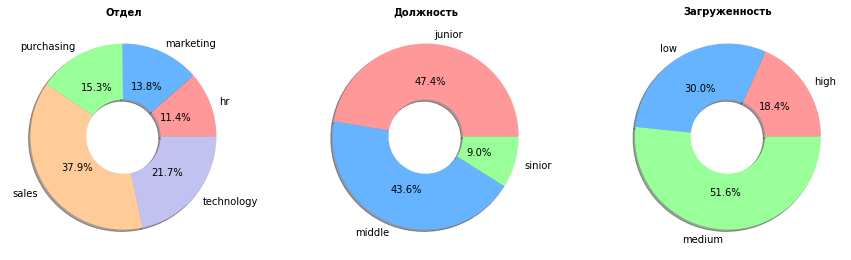

In [29]:
# построим круговую диаграмму для категориальных признаков тренировочной выборки
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
fig.subplots_adjust(wspace=0.3)
draw_circle(axs[0], train_job, 'dept', "Отдел")
draw_circle(axs[1], train_job, 'level', "Должность")
draw_circle(axs[2], train_job, 'workload', "Загруженность")

Самым многочисленным является отдел `sales`, здесь работает 37.9% сотрудников, на втором месте по численности отдел `technology` - 21.7%, на третьем месте `purchasing` - 15.3%. Самый малочисленный отдел `hr` - 11.4%.
<br> Больше всего в компании сотрудников работает на должности junior - 47.4%, 43.6% составляют middle специалисты и 9% - sinior.
<br> 30% сотрудников имеют низкий уровень загруженности, 51.6% - средний и 18.4% - высокий. 

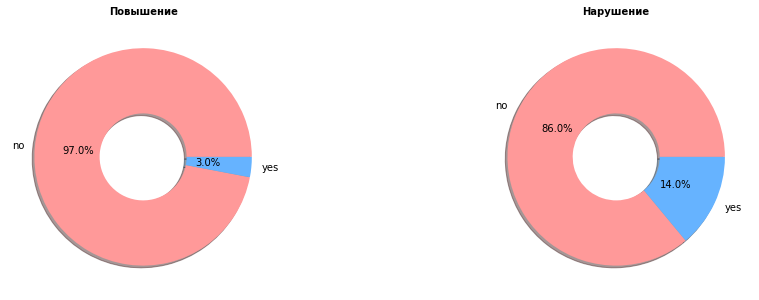

In [30]:
# построим круговую диаграмму для категориальных признаков тренировочной выборки
fig, axs = plt.subplots(1, 2, figsize=(15, 5)) 
fig.subplots_adjust(wspace=0.3)
draw_circle(axs[0], train_job, 'last_year_promo', "Повышение")
draw_circle(axs[1], train_job, 'last_year_violations', "Нарушение")

3% сотрудников повышены за последний год.
<br> 14% сотрудников нарушали трудовой договор за последний год.

#### Количественные признаки

##### Длительность работы в компании

In [31]:
#sorted(train_job['employment_years'].unique())

In [32]:
# вызовем функцию построим частотную гистограмму распределения и ящик с усами для длительности работы в компании 
#draw_quantity(train_job['employment_years'], 30)

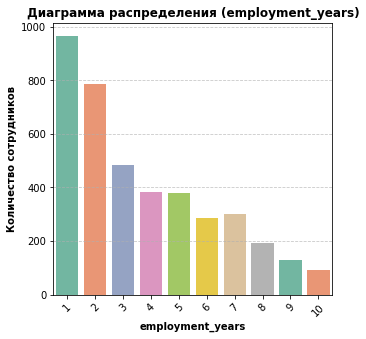

In [33]:
# вызовем функцию построения столбчатой диаграммы для дискретных количественных признаков
draw_bar_chart_for_discrete_feature(train_job, 'employment_years')

Средняя продолжительность работы в компании составляет 3 года, при этом только 25% сотрудников работают более 6 лет.

##### Оценка руководителя

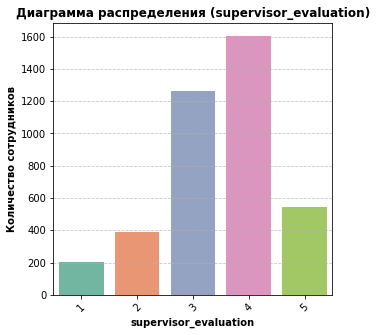

In [37]:
# вызовем функцию построения столбчатой диаграммы для дискретных количественных признаков
draw_bar_chart_for_discrete_feature(train_job, 'supervisor_evaluation')

Большая часть сотрудников имеют оценку руководителя 3 или 4.

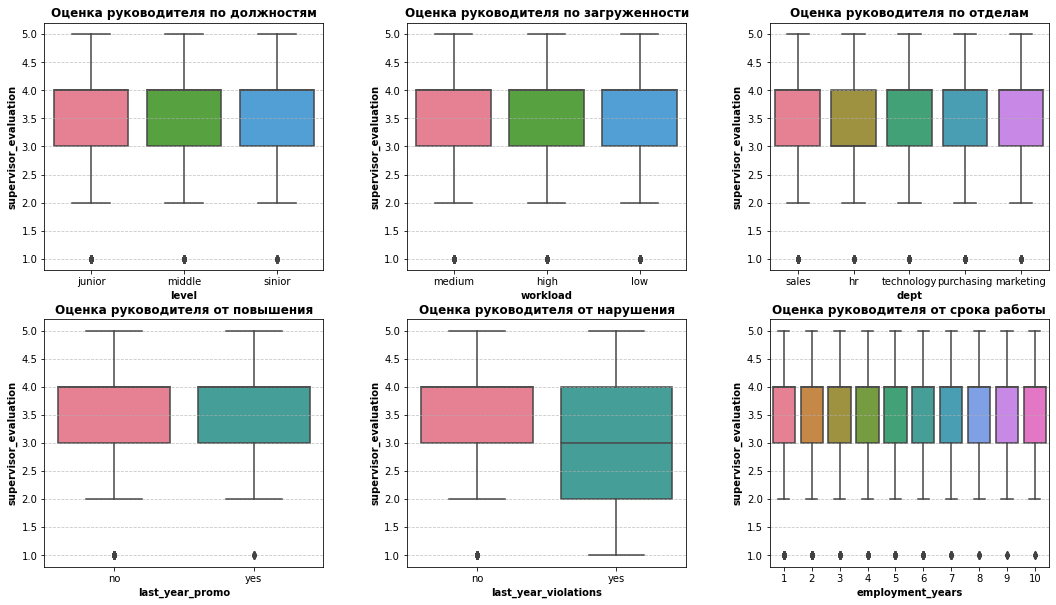

In [39]:
# вызовем функцию построения диаграммы размаха в разбивке по категориям
fig, axs = plt.subplots(2, 3, figsize=(18, 10)) 
fig.subplots_adjust(wspace=0.3)
draw_scope(axs[0, 0], train_job, 'level', 'supervisor_evaluation', 20, "Оценка руководителя по должностям")
draw_scope(axs[0, 1], train_job, 'workload', 'supervisor_evaluation', 20, "Оценка руководителя по загруженности")
draw_scope(axs[0, 2], train_job, 'dept', 'supervisor_evaluation', 20, "Оценка руководителя по отделам")
draw_scope(axs[1, 0], train_job, 'last_year_promo', 'supervisor_evaluation', 20, "Оценка руководителя от повышения")
draw_scope(axs[1, 1], train_job, 'last_year_violations', 'supervisor_evaluation', 20, "Оценка руководителя от нарушения")
draw_scope(axs[1, 2], train_job, 'employment_years', 'supervisor_evaluation', 20, "Оценка руководителя от срока работы")

На оценку руководителя из приведенных выше признаков существенным образом влияет только наличие нарушений сотрудником трудового договора за последний год.

##### Ежемесячная зарплата 

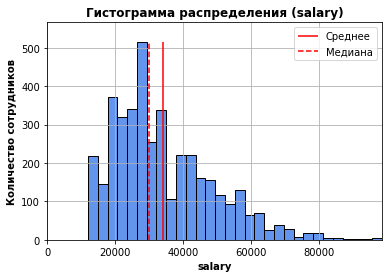

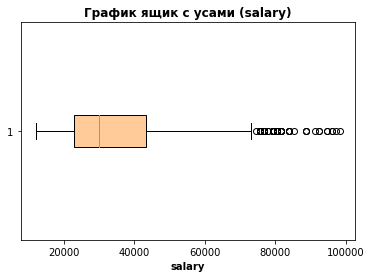

count     4000.0
mean     33926.7
std      14900.7
min      12000.0
2.5%     12000.0
25%      22800.0
50%      30000.0
75%      43200.0
97.5%    68400.0
max      98400.0
Name: salary, dtype: float64

In [41]:
draw_quantity(train_job['salary'], 30)

Заработная плата изменяется в диапазоне от 12000 до 98400, при этом среднее значение составляет 30000.

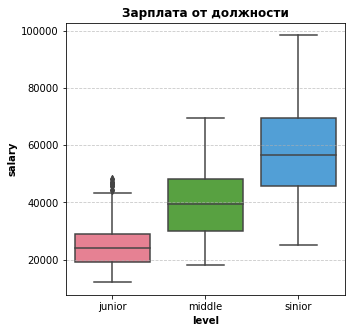

In [42]:
# вызовем функцию построения диаграммы размаха в разбивке по категориям
fig, axs = plt.subplots(1, 1, figsize=(5, 5)) 
fig.subplots_adjust(wspace=0.3)
draw_scope(axs, train_job, 'level', 'salary', 20, "Зарплата от должности")

In [43]:
# выведем числовое описание данных
round(train_job[['level', 'salary']].groupby('level').describe())

salary                                                               
         count     mean      std      min      25%      50%      75%      max
level                                                                        
junior  1894.0  24200.0   7251.0  12000.0  19200.0  24000.0  28800.0  48000.0
middle  1744.0  39714.0  12256.0  18000.0  30000.0  39600.0  48300.0  69600.0
sinior   358.0  57292.0  16150.0  25200.0  45600.0  56400.0  69600.0  98400.0

Отмечается логичный рост заработной платы с повышением уровня занимаемой должности. Средний уровень з/п junior - 24200, middle - 39714 и sinior - 57292. Минимальный разброс заработной платы отмечается на должности junior, максимальный у sinior.      

In [44]:
# создадим функцию построения lineplot для групп данных
def draw_lineplot_for_groups(df, parameter_1, parameter_2):
    # cоздаем сетку значений по оси X
    x_range = np.linspace(df[parameter_1].min(), df[parameter_1].max(), 100)
    plt.figure(figsize=(10, 5))

    # итерация по уникальным значениям параметра 2
    for group in df[parameter_2].unique():
        subset = df[df[parameter_2] == group]
        sns.kdeplot(subset[parameter_1], label=group, lw=2)
    
    # настройка графика
    plt.title('Плотность распределени для разных уровней {parameter_1}', fontsize=12, fontweight="bold")
    plt.xlabel(parameter_1, fontsize=10, fontweight="bold")
    plt.ylabel('Плотность', fontsize=10, fontweight="bold")
    plt.legend(title=parameter_2)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

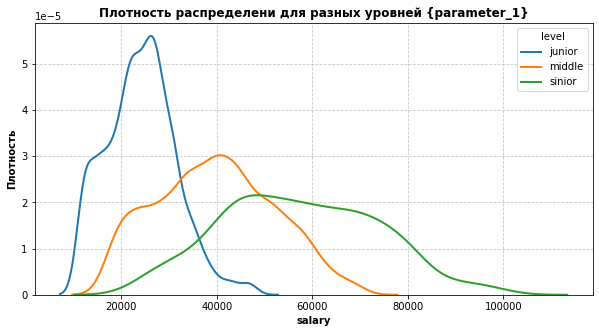

In [45]:
# вызовем функцию построения lineplot для групп данных
draw_lineplot_for_groups(
    train_job, 
    parameter_1='salary', 
    parameter_2='level'
)

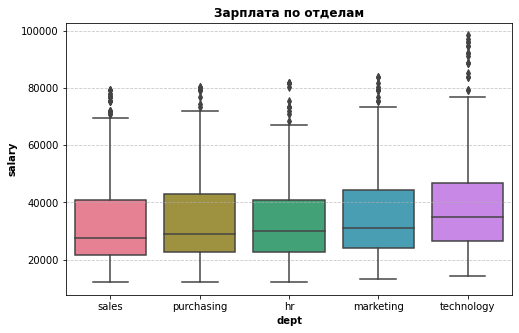

In [46]:
# вызовем функцию построения диаграммы размаха в разбивке по категориям
fig, axs = plt.subplots(1, 1, figsize=(8, 5)) 
fig.subplots_adjust(wspace=0.3)
draw_scope(axs, train_job.sort_values('salary'), 'dept', 'salary', 20, "Зарплата по отделам")

In [47]:
# выведем числовое описание данных
round(train_job[['dept', 'salary']].groupby('dept').describe())

salary                                                        \
             count     mean      std      min      25%      50%      75%   
dept                                                                       
hr           456.0  33174.0  14448.0  12000.0  22800.0  30000.0  40800.0   
marketing    550.0  34353.0  15158.0  13200.0  24000.0  31200.0  44400.0   
purchasing   610.0  33094.0  14339.0  12000.0  22800.0  28800.0  42900.0   
sales       1512.0  31696.0  13793.0  12000.0  21600.0  27600.0  40800.0   
technology   866.0  38615.0  16154.0  14400.0  26400.0  34800.0  46800.0   

                     
                max  
dept                 
hr          81600.0  
marketing   84000.0  
purchasing  80400.0  
sales       79200.0  
technology  98400.0

Самая высокая з/п в отделе `technology`, самая низкая в `sales`. 

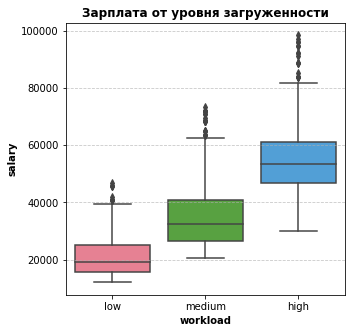

In [51]:
# вызовем функцию построения диаграммы размаха в разбивке по категориям
fig, axs = plt.subplots(1, 1, figsize=(5, 5)) 
fig.subplots_adjust(wspace=0.3)
draw_scope(axs, train_job.sort_values('salary'), 'workload', 'salary', 20, "Зарплата от уровня загруженности")

In [52]:
# выведем числовое описание данных
round(train_job[['workload', 'salary']].groupby('workload').describe())

salary                                                        \
           count     mean      std      min      25%      50%      75%   
workload                                                                 
high       734.0  53845.0  13516.0  30000.0  46800.0  53400.0  61200.0   
low       1200.0  21267.0   6875.0  12000.0  15600.0  19200.0  25200.0   
medium    2066.0  34203.0  10172.0  20400.0  26400.0  32400.0  40800.0   

                   
              max  
workload           
high      98400.0  
low       46800.0  
medium    73200.0

Чем выше уровень загруженности сотрудников, тем выше заработная плата.

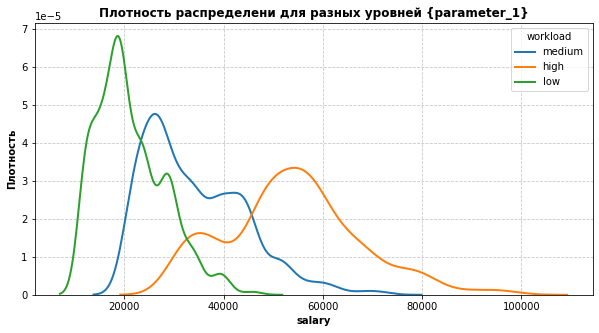

In [53]:
# вызовем функцию построения lineplot для групп данных
draw_lineplot_for_groups(
    train_job, 
    parameter_1='salary', 
    parameter_2='workload'
)

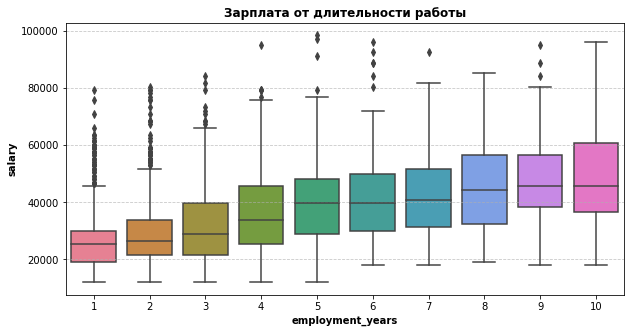

In [54]:
# вызовем функцию построения диаграммы размаха в разбивке по категориям
fig, axs = plt.subplots(1, 1, figsize=(10, 5)) 
fig.subplots_adjust(wspace=0.3)
draw_scope(axs, train_job, 'employment_years', 'salary', 20, "Зарплата от длительности работы")

In [55]:
# выведем числовое описание данных
round(train_job[['employment_years', 'salary']].groupby('employment_years').describe())

salary                                                        \
                  count     mean      std      min      25%      50%      75%   
employment_years                                                                
1                 966.0  26031.0  10102.0  12000.0  19200.0  25200.0  30000.0   
2                 785.0  28811.0  12066.0  12000.0  21600.0  26400.0  33600.0   
3                 483.0  32025.0  14104.0  12000.0  21600.0  28800.0  39600.0   
4                 384.0  35550.0  14451.0  12000.0  25200.0  33600.0  45600.0   
5                 380.0  40042.0  14464.0  12000.0  28800.0  39600.0  48000.0   
6                 287.0  41260.0  14700.0  18000.0  30000.0  39600.0  49800.0   
7                 301.0  41856.0  14257.0  18000.0  31200.0  40800.0  51600.0   
8                 193.0  45140.0  15668.0  19200.0  32400.0  44400.0  56400.0   
9                 130.0  46615.0  15398.0  18000.0  38400.0  45600.0  56400.0   
10                 91.0  48316.0  16154.0  18000.0  36600.0  45600.0  60600.0   

                           
                      max  
employment_years           
1                 79200.0  
2                 80400.0  
3                 84000.0  
4                 94800.0  
5                 98400.0  
6                 96000.0  
7                 92400.0  
8                 85200.0  
9                 94800.0  
10                96000.0

С увеличением длительности работы в компании заработная плата сотрудников растет.

##### Уровень удовлетворённости

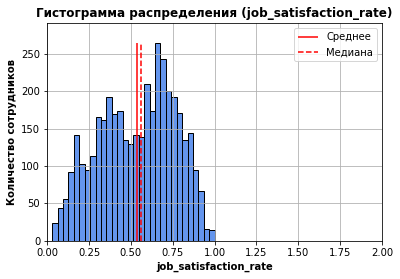

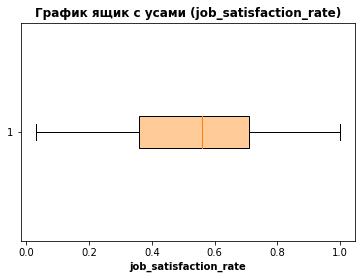

count    4000.0
mean        0.5
std         0.2
min         0.0
2.5%        0.1
25%         0.4
50%         0.6
75%         0.7
97.5%       0.9
max         1.0
Name: job_satisfaction_rate, dtype: float64

In [57]:
# вызовем функцию построим частотную гистограмму распределения и ящик с усами для длительности работы в компании 
draw_quantity(train_job['job_satisfaction_rate'], 30)

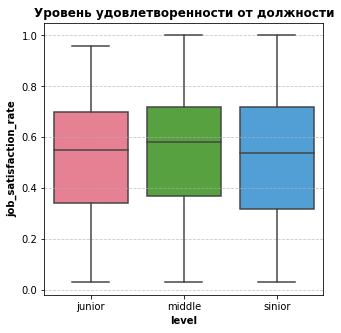

In [58]:
# вызовем функцию построения диаграммы размаха в разбивке по категориям
fig, axs = plt.subplots(1, 1, figsize=(5, 5)) 
fig.subplots_adjust(wspace=0.3)
draw_scope(axs, train_job, 'level', 'job_satisfaction_rate', 20, "Уровень удовлетворенности от должности")

In [59]:
# выведем числовое описание данных
round(train_job[['level', 'job_satisfaction_rate']].groupby('level').describe(), 3)

job_satisfaction_rate                                             
                       count   mean    std   min   25%   50%    75%   max
level                                                                    
junior                1894.0  0.523  0.227  0.03  0.34  0.55  0.700  0.96
middle                1744.0  0.548  0.221  0.03  0.37  0.58  0.720  1.00
sinior                 358.0  0.520  0.238  0.03  0.32  0.54  0.718  1.00

Самыми удовлетворенными являются middle специалисты.

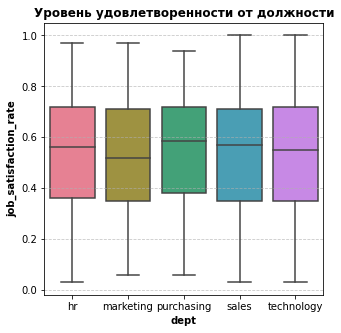

In [60]:
# вызовем функцию построения диаграммы размаха в разбивке по категориям
fig, axs = plt.subplots(1, 1, figsize=(5, 5)) 
fig.subplots_adjust(wspace=0.3)
draw_scope(axs, train_job.sort_values('dept'), 'dept', 'job_satisfaction_rate', 20, "Уровень удовлетворенности от должности")

In [61]:
# выведем числовое описание данных
round(train_job[['dept', 'job_satisfaction_rate']].groupby('dept').describe(), 3)

job_satisfaction_rate                                           \
                           count   mean    std   min    25%    50%    75%   
dept                                                                        
hr                         456.0  0.536  0.225  0.03  0.360  0.560  0.720   
marketing                  550.0  0.524  0.224  0.06  0.350  0.520  0.710   
purchasing                 610.0  0.552  0.210  0.06  0.382  0.585  0.718   
sales                     1512.0  0.534  0.228  0.03  0.350  0.570  0.710   
technology                 866.0  0.526  0.231  0.03  0.350  0.550  0.718   

                  
             max  
dept              
hr          0.97  
marketing   0.97  
purchasing  0.94  
sales       1.00  
technology  1.00

Самыми удовлетворенными выглядят сотрудники отдела purchasing, самыми неудовлетворенными сотрудники отдела marketing.

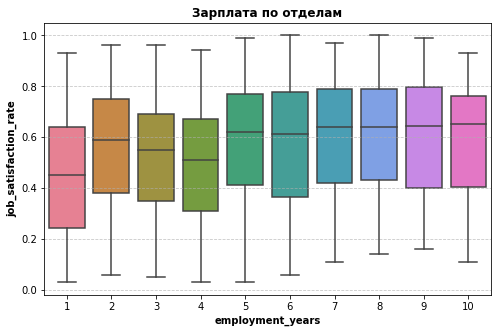

In [62]:
# вызовем функцию построения диаграммы размаха в разбивке по категориям
fig, axs = plt.subplots(1, 1, figsize=(8, 5)) 
fig.subplots_adjust(wspace=0.3)
draw_scope(axs, train_job, 'employment_years', 'job_satisfaction_rate', 20, "Зарплата по отделам")

In [63]:
# выведем числовое описание данных
round(train_job[['employment_years', 'job_satisfaction_rate']].groupby('employment_years').describe(), 3)

job_satisfaction_rate                                    \
                                 count   mean    std   min    25%    50%   
employment_years                                                           
1                                966.0  0.444  0.215  0.03  0.242  0.450   
2                                785.0  0.564  0.217  0.06  0.380  0.590   
3                                483.0  0.528  0.220  0.05  0.350  0.550   
4                                384.0  0.487  0.220  0.03  0.308  0.510   
5                                380.0  0.583  0.220  0.03  0.410  0.620   
6                                287.0  0.572  0.234  0.06  0.365  0.610   
7                                301.0  0.611  0.204  0.11  0.420  0.640   
8                                193.0  0.617  0.207  0.14  0.430  0.640   
9                                130.0  0.611  0.213  0.16  0.400  0.645   
10                                91.0  0.597  0.210  0.11  0.405  0.650   

                               
                    75%   max  
employment_years               
1                 0.640  0.93  
2                 0.750  0.96  
3                 0.690  0.96  
4                 0.670  0.94  
5                 0.770  0.99  
6                 0.775  1.00  
7                 0.790  0.97  
8                 0.790  1.00  
9                 0.798  0.99  
10                0.760  0.93

Самыми удовлетворенными являются сотрудники, работающие в компании 7-9 лет, самыми неудовлетворенными - работающие 1 год.

### Корреляционный анализ

Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками.

In [66]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['id', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
# считаем корреляции
phik_overview = phik_matrix(train_job, interval_cols=interval_cols) 

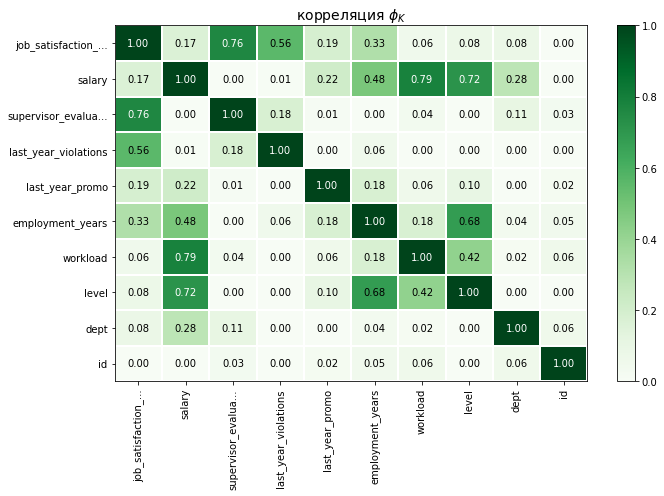

In [67]:
# вызовем функцию для отрисовки матрицы корреляций
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'корреляция $\phi_K$',
    fontsize_factor=1,
    figsize=(10, 7)
) 

Мультиколлинеарности, то есть сильной линейной взаимосвязи между входными количественными признаками не наблюдается.

Из матрицы корреляций можно сделать следующие выводы:

На уровень удовлетворённости сотрудника работой в компании больше всего влияет оценка качества работы сотрудника, при этом связь между этими параметрами высокая с коэффициентом корреляции 0.76. 

Уровень удовлетворённости сотрудника заметно влияет на нарушение сотрудником трудового договора за последний год (коэффициент корреляции 0.56).

Умеренное влияние на уровень удовлетворённости сотрудника оказывает длительность работы в компании, коэффициент корреляции 0.33.

Ежемесячная зарплата сотрудника и было ли повышение за последний год имеют слабое влияние на уровень удовлетворённости (коэффициент корреляции 0.17 и 0.19 соответственно). 

In [68]:
new_train_job = train_job.drop('id', 1) 

In [69]:
# проверим наличие дубликатов после удаления id
duplicates = new_train_job[new_train_job.duplicated()]
print(f"Количество дубликатов в train_job: {duplicates.shape[0]}")

# удалим дубликаты
train_job_cleaned = new_train_job.drop_duplicates()
print(f"Количество строк после удаления дубликатов в train_job: {train_job_cleaned.shape[0]}")

Количество дубликатов в train_job: 245
Количество строк после удаления дубликатов в train_job: 3755


### Построение модели 1

Создадим модель, которая будет прогнозировать целевой признак - уровень удовлетворённости сотрудника. В данном случае мы имеем дело с задачей численной регрессии.

In [70]:
# проверим соответствие входных признаков и целевого для тестовой выборки 
test_input_cleaned = test_input.merge(test_job, on='id', how='inner')
test_input_cleaned = test_input_cleaned.drop('id', 1) 

In [71]:
# создание констант
RANDOM_STATE = 42

# зададим тренировочную и тестовую выборки
X_train = train_job_cleaned.drop('job_satisfaction_rate', axis=1)
y_train  = train_job_cleaned['job_satisfaction_rate'] 
X_test = test_input_cleaned.drop('job_satisfaction_rate', axis=1)
y_test = test_input_cleaned['job_satisfaction_rate'] 

# списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

# пайплайн для признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, categories='auto'))
    ]
)

# пайплайн для признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline(
    steps=[
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],  # порядок уровней в "level"
                    ['low', 'medium', 'high']  # порядок уровней в "workload"
                ], 
                handle_unknown='use_encoded_value', unknown_value=-1  
            )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=-1, strategy='most_frequent'))  # указываем -1 как значение для замены
    ]
)

# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных - 'preprocessor' и модель - 'models'
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# гиперпараметры для подбора
param_distributions = [
    # словарь для модели DecisionTreeRegressor()
    {   
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],  
        'models__max_depth': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
]

# создадим функцию новой метрики для оценки качества модели
def custom_metric(y_true, y_pred):
    return (100/len (y_true)) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# создание пользовательской метрики
SMAPE = make_scorer(custom_metric, greater_is_better=False) 

# настройка RandomizedSearchCV с валидацией
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    n_iter=20,
    scoring=SMAPE,  # Передаем созданный объект SMAPE
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

randomized_search.fit(X_train, y_train) 

# выведем лучшие параметры
best_model = randomized_search.best_estimator_
print('Метрика SMAPE для лучшей модели:', round(-1*randomized_search.best_score_, 2))
print('\nЛучшая модель и её параметры:\n\n', best_model)

# проверка модели на тестовой выборке
y_test_pred = best_model.predict(X_test)

# вычисленим SMAPE на тестовой выборке
smape_test = custom_metric(y_test, y_test_pred)
print(f'Метрика SMAPE на тестовой выборке: {smape_test:.2f}')

Метрика SMAPE для лучшей модели: 15.5

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                              

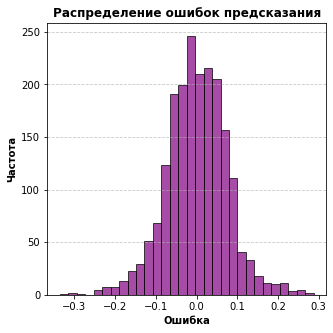

In [72]:
# вычислим ошибки модели на тестовой выборке
errors = y_test_pred - y_test

# визуализируем распределения ошибок
plt.figure(figsize=(5, 5))
plt.hist(errors, bins=30, color='purple', edgecolor='black', alpha=0.7)
plt.title('Распределение ошибок предсказания', fontsize=12, fontweight="bold") 
plt.xlabel('Ошибка', fontsize=10, fontweight="bold") 
plt.ylabel('Частота', fontsize=10, fontweight="bold") 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

DecisionTreeRegressor показала лучшие результаты по сравнению с LinearRegression, что может свидетельствовать о том, что линейные зависимости не полностью описывают структуру данных.

Посмотрим какие правила сформировало дерево решений и какие признаки в них участвовали. Оценим первые два уровня правил.

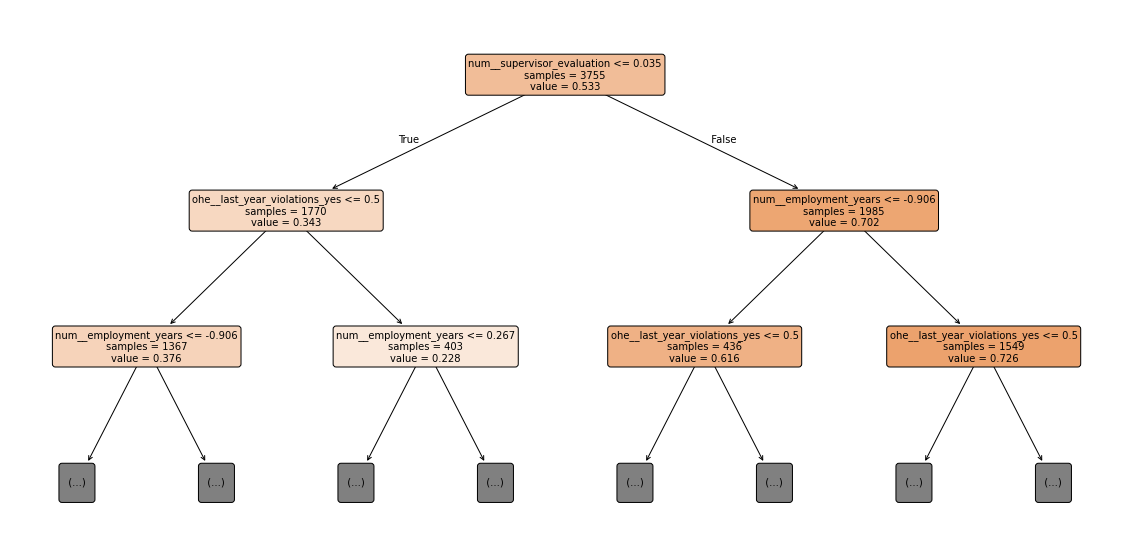

In [73]:
# извлекаем модель из пайплайна
decision_tree_model = best_model.named_steps['models']

# преобразуем данные для визуализации 
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
# получаем имена признаков
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# визуализируем дерево решений
plt.figure(figsize=(20, 10))  # Задайте размер фигуры для лучшего отображения
plot_tree(
    decision_tree_model, 
    max_depth=2, 
    filled=True, 
    impurity=False,
    rounded=True,
    feature_names=feature_names,
    fontsize=10

)
plt.show()

Отобразим важность признаков лучшей модели на графике.

In [74]:
# создаем таблицу с важностью признаков
feature_importances = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': decision_tree_model.feature_importances_
    }
).sort_values('Importance', ascending=False)

# выводим таблицу с важностью признаков
feature_importances

,Feature,Importance
9,num__supervisor_evaluation,0.683438
10,num__salary,0.076345
8,num__employment_years,0.072751
5,ohe__last_year_violations_yes,0.055350
6,ord__level,0.047920
7,ord__workload,0.018471
2,ohe__dept_sales,0.014338
4,ohe__last_year_promo_yes,0.010900
0,ohe__dept_marketing,0.009331
3,ohe__dept_technology,0.008750


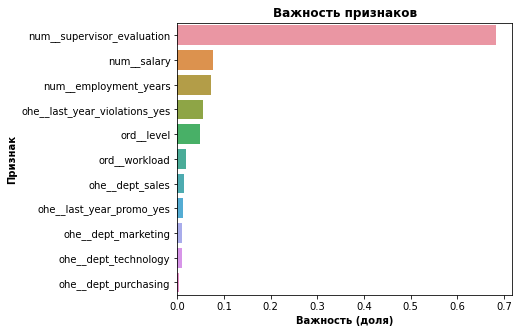

In [75]:
# визуализируем важность признаков
plt.figure(figsize=(6, 5))
# столбчатый график важности признаков
ax = sns.barplot(x='Importance', y='Feature', data=feature_importances)
# названия графика и осей
ax.set_title('Важность признаков', fontsize=12, fontweight="bold")
ax.set_xlabel('Важность (доля)', fontsize=10, fontweight="bold")
ax.set_ylabel('Признак', fontsize=10, fontweight="bold")
# отображаем график
plt.show()

Оценка качества работы сотрудника руководителем является наиболее значимым фактором, влияющим на решение сотрудника остаться или уйти из компании. Высокая оценка может мотивировать сотрудников и увеличить их приверженность компании, тогда как низкая оценка может способствовать их уходу.

In [76]:
# создание и обучение DummyRegressor
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)

# предсказание на тестовой выборке с помощью DummyRegressor
y_test_pred_dummy = dummy_regressor.predict(X_test)

# вычисление метрики SMAPE для константной модели
smape_dummy = custom_metric(y_test, y_test_pred_dummy)
print(f'Метрика SMAPE для константной модели: {smape_dummy:.2f}')

# сравнение с лучшей моделью
smape_best_model = custom_metric(y_test, y_test_pred)
print(f'Метрика SMAPE для лучшей модели: {smape_best_model:.2f}')

if smape_best_model < smape_dummy:
    print('Лучшая модель превосходит константную модель.')
else:
    print('Константная модель работает не хуже лучшей модели.')

Метрика SMAPE для константной модели: 38.26
Метрика SMAPE для лучшей модели: 13.63
Лучшая модель превосходит константную модель.


## Задача 2: предсказание уровня удовлетворённости

### Добавление нового входного признака

Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [77]:
new_train_quit = train_quit.drop('id', 1)

In [78]:
# проверим наличие дубликатов после удаления id
duplicates = new_train_quit[new_train_quit.duplicated()]
print(f"Количество дубликатов train_quit: {duplicates.shape[0]}")

# удалим дубликаты
train_quit_cleaned = new_train_quit.drop_duplicates()
print(f"Количество строк после удаления дубликатов train_quit: {train_job_cleaned.shape[0]}")

Количество дубликатов train_quit: 1413
Количество строк после удаления дубликатов train_quit: 3755


In [79]:
# сохраним входные признаки в переменную X
X = train_quit_cleaned.drop('quit', axis=1)

# сохраним целевой признак в переменную y
y = train_quit_cleaned['quit'] 

In [80]:
# получим прогноз, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи
X['job_satisfaction_rate'] = best_model.predict(X)

In [81]:
train_quit_cleaned = X.join(y)

In [82]:
# объединение и подготовка тестовой выборки
test_input_cleaned = test_input.merge(test_job, on='id', how='inner').merge(test_quit, on='id', how='inner')
test_input_cleaned = test_input_cleaned.drop('id', axis=1)

### Исследовательский анализ данных

Разделим признаки на две группы:
1. Категориальные:
    - порядковые `level`, `workload`;
    - бинарные `last_year_promo`, `last_year_violations`, `quit`; 
    - номинальные `dept`; 
2. Количественные: `employment_years`, `supervisor_evaluation`, `salary`, `job_satisfaction_rate`.

#### Категориальные признаки

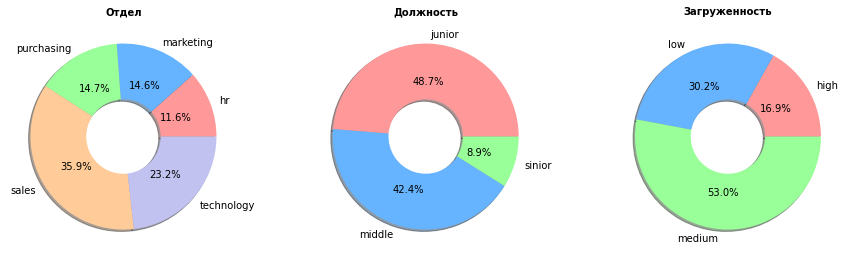

In [83]:
# построим круговую диаграмму для категориальных признаков тренировочной выборки
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
fig.subplots_adjust(wspace=0.3)
draw_circle(axs[0], train_quit, 'dept', "Отдел")
draw_circle(axs[1], train_quit, 'level', "Должность")
draw_circle(axs[2], train_quit, 'workload', "Загруженность")

Самым многочисленным является отдел `sales`, здесь работает 35.9% сотрудников, на втором месте по численности отдел `technology` - 23.2%, на третьем месте `purchasing` - 14.7%. Самый малочисленный отдел `hr` - 11.6%.
<br> Больше всего в компании сотрудников работает на должности junior - 48.7%, 42.4% составляют middle специалисты и 8.9% - sinior. 
<br> 30.2% сотрудников имеют низкий уровень загруженности, 53% - средний и 16.9% - высокий.

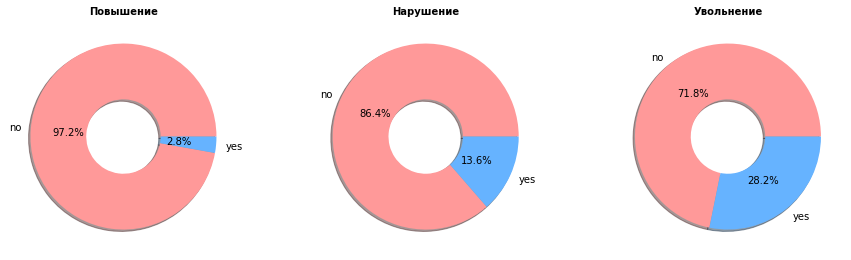

In [84]:
# построим круговую диаграмму для категориальных признаков тренировочной выборки
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
fig.subplots_adjust(wspace=0.3)
draw_circle(axs[0], train_quit, 'last_year_promo', "Повышение")
draw_circle(axs[1], train_quit, 'last_year_violations', "Нарушение")
draw_circle(axs[2], train_quit, 'quit', "Увольнение")

2.8% сотрудников повышены за последний год.
<br> 13.6% сотрудников нарушали трудовой договор за последний год.
<br> 28.2% сотрудников уволились из компании.

#### Портрет «уволившегося сотрудника»

Составим портрет «уволившегося сотрудника».

In [85]:
# создадим функция для построения графика относительной частоты
def plot_relative_frequency(df, parametr_1, parametr_2):
    # Подсчет частот для каждого значения категориального признака и статуса увольнения
    counts = df.groupby([parametr_1, parametr_2]).size().unstack().fillna(0)
    
    # Нормирование частот
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Построение столбчатой диаграммы
    plt.figure(figsize=(8, 6))
    proportions.plot(kind='bar', stacked=False, color=['green', 'red',], edgecolor='black')
    
    plt.title(f'Динамика увольнения сотрудников  по {parametr_1}', fontsize=12, fontweight="bold")
    plt.xlabel(parametr_1, fontsize=10, fontweight="bold")
    plt.ylabel('Доля сотрудников', fontsize=10, fontweight="bold")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Увольнение')
    plt.show()

<Figure size 576x432 with 0 Axes>

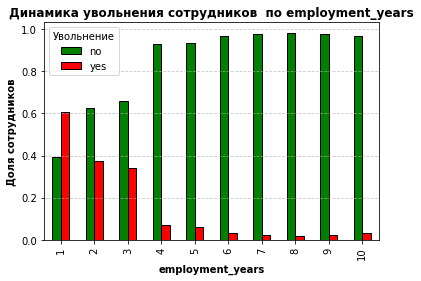

In [86]:
# вызовем функцию для построения графика относительной частоты
plot_relative_frequency(train_quit, 'employment_years', 'quit')

Чаще всего увольняются сотрудники, которые работают в компании 1-3 года.  

<Figure size 576x432 with 0 Axes>

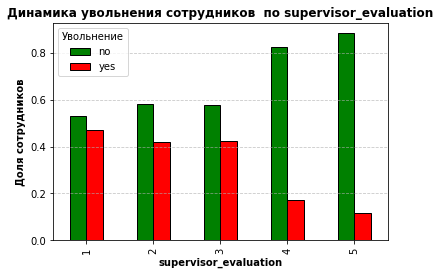

In [87]:
# вызовем функцию для построения графика относительной частоты
plot_relative_frequency(train_quit, 'supervisor_evaluation', 'quit')

Увольняющиеся сотрудники чаще имеют оценку качества работы руководителем на уровне 1-3.

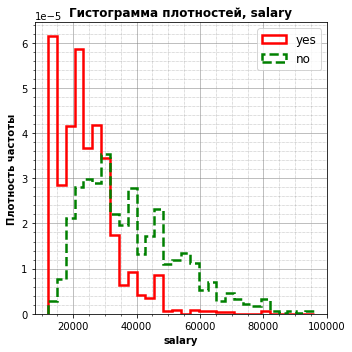

In [88]:
# вызовем функцию построения гистограмм плотностей для групп
hist_density(
    train_quit, 
    [train_quit.query('quit == "yes"').reset_index(drop=True), 
    train_quit.query('quit == "no"').reset_index(drop=True),],
    parametr_1='salary',
    parametr_2='quit',
    bins=30)

In [89]:
# создадим функцию для визуализации распределения признаков для ушедших и оставшихся сотрудников
def plot_job_satisfaction_distribution(df, x, y):
    plt.figure(figsize=(9, 6))

    # гистограмма плотности распределения (KDE) для уровня удовлетворённости работой
    sns.kdeplot(data=df[df['quit'] == 'yes'], x=x, fill=True, label='Ушедшие', color='red', alpha=0.6)
    sns.kdeplot(data=df[df['quit'] == 'no'], x=x, fill=True, label='Оставшиеся', color='green', alpha=0.6)

    plt.title(f'Распределение {x} для ушедших и оставшихся сотрудников', fontsize=12, fontweight="bold")
    plt.xlabel(x, fontsize=10, fontweight="bold")
    plt.ylabel('Плотность', fontsize=10, fontweight="bold")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # построение boxplot для визуального сравнения
    plt.figure(figsize=(9, 6))
    sns.boxplot(x=x, y=y, data=df, palette=['green', 'red'])
    plt.title(f'Boxplot {x} для ушедших и оставшихся сотрудников', fontsize=12, fontweight="bold")
    plt.xlabel(x, fontsize=10, fontweight="bold")
    plt.ylabel('Статус увольнения', fontsize=10, fontweight="bold")
    plt.show()

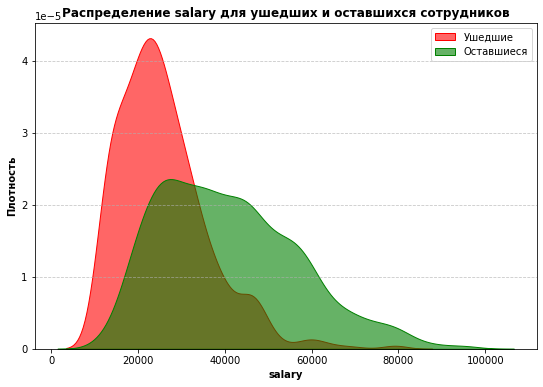

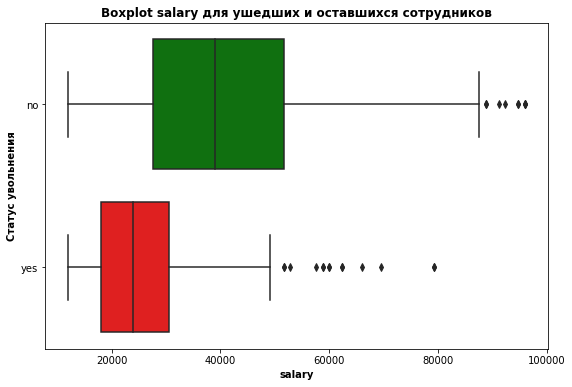

In [90]:
# вызовем функцию для визуализации распределения признаков для ушедших и оставшихся сотрудников
plot_job_satisfaction_distribution(train_quit_cleaned, 'salary', 'quit')

In [91]:
# выведем числовое описание данных
round(train_quit_cleaned[['quit', 'salary']].groupby('quit').describe(), 2)

salary                                                                 
       count      mean       std      min      25%      50%      75%      max
quit                                                                         
no    1932.0  40952.17  16085.74  12000.0  27600.0  39000.0  51600.0  96000.0
yes    655.0  25767.94  10484.83  12000.0  18000.0  24000.0  30600.0  79200.0

Чаще увольняются сотрудники с заработной платой до 30000. Сотрудники, которые остались в компании, имеют более высокие зарплаты в среднем по сравнению с ушедшими (39000 против 24000).

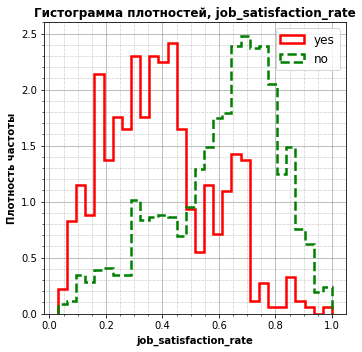

In [92]:
# вызовем функцию построения гистограмм плотностей для групп
hist_density(
    test_input_cleaned, 
    [test_input_cleaned.query('quit == "yes"').reset_index(drop=True), 
    test_input_cleaned.query('quit == "no"').reset_index(drop=True),],
    parametr_1='job_satisfaction_rate',
    parametr_2='quit',
    bins=30)

Чаще всего увольняются сотрудники с уровнем удовлетворености до 0.5.

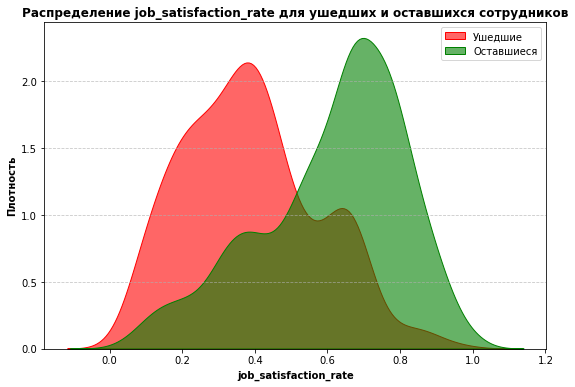

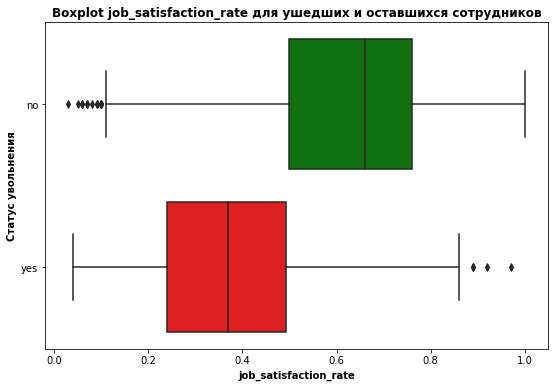

In [93]:
# вызовем функцию для визуализации распределения признаков для ушедших и оставшихся сотрудников
plot_job_satisfaction_distribution(test_input_cleaned, 'job_satisfaction_rate', 'quit')

In [94]:
# выведем числовое описание данных
round(test_input_cleaned[['quit', 'job_satisfaction_rate']].groupby('quit').describe(), 2)

job_satisfaction_rate                                          
                     count  mean   std   min   25%   50%   75%   max
quit                                                                
no                  1436.0  0.61  0.20  0.03  0.50  0.66  0.76  1.00
yes                  564.0  0.39  0.19  0.04  0.24  0.37  0.49  0.97

У ушедших сотрудников средний уровень удовлетворённости составляет 0.37, что заметно ниже, чем у оставшихся сотрудников (0.65). Это подтверждает гипотезу о том, что сотрудники с более низким уровнем удовлетворённости работой чаще уходят из компании.

<Figure size 576x432 with 0 Axes>

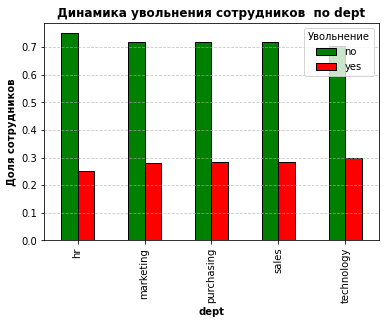

In [96]:
# вызовем функцию для построения графика относительной частоты
plot_relative_frequency(train_quit, 'dept', 'quit')

С учетом численности отделов, чаще других увольняются сотрудники отдела technology, реже всего сотрудники отдела hr.

<Figure size 576x432 with 0 Axes>

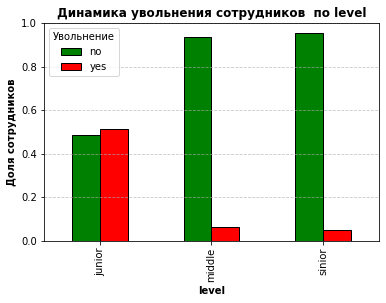

In [97]:
# вызовем функцию для построения графика относительной частоты
plot_relative_frequency(train_quit, 'level', 'quit')

Чаще всего увольняются сотрудники с должностью junior.

<Figure size 576x432 with 0 Axes>

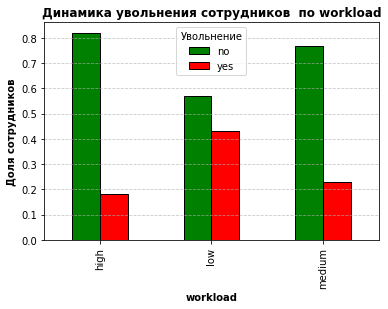

In [98]:
# вызовем функцию для построения графика относительной частоты
plot_relative_frequency(train_quit, 'workload', 'quit')

Чаще других увольняются сотрудники с низким уровнем загруженности.

<Figure size 576x432 with 0 Axes>

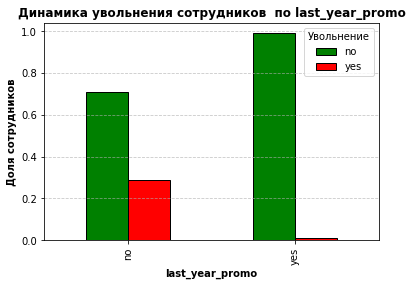

In [99]:
# вызовем функцию для построения графика относительной частоты
plot_relative_frequency(train_quit, 'last_year_promo', 'quit')

Сотрудники, которых не повышали в прошлом году увольняются  намного чаще.

<Figure size 576x432 with 0 Axes>

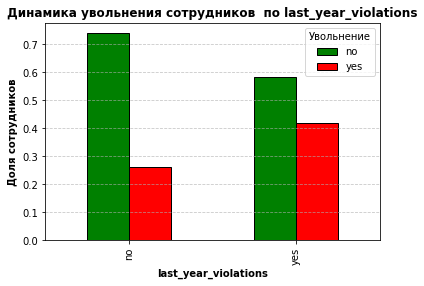

In [100]:
# вызовем функцию для построения графика относительной частоты
plot_relative_frequency(train_quit, 'last_year_violations', 'quit')

Сотрудники, которые нарушали трудовой договор за последний год увольняются чаще.

Чаще других увольняются сотрудники со следующими параметрами:
- работают в компании 1-3 года,
- оценка качества работы руководителем на уровне 1-3,
- заработная плата до 30000,
- должность junior,
- низкий уровнь загруженности,
- уровень удовлетворености до 0.5,
- не имели повышения в прошлом году,
- нарушали трудовой договор за последний год.

### Корреляционный анализ

In [101]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
# считаем корреляции
phik_overview = phik_matrix(train_quit_cleaned, interval_cols=interval_cols) 

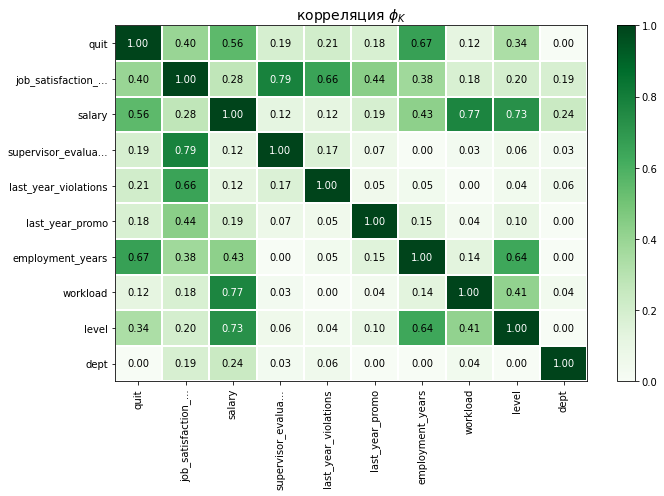

In [102]:
# вызовем функцию для отрисовки матрицы корреляций
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'корреляция $\phi_K$',
    fontsize_factor=1,
    figsize=(10, 7)
) 

Мультиколлинеарности, то есть сильной линейной взаимосвязи между входными количественными признаками не наблюдается.

Из матрицы корреляций можно сделать следующие выводы:

На увольнение сотрудника из компании заметнее всего влияет длительность работы (коэффициент корреляции 0.67). Также заметное влияние оказывают уровень заработной платы и уровень удовлетворённости сотрудника работой в компании (коэффициент корреляции 0.56 и 0.4 соответственно). 

Умеренное влияние на увольнение сотрудника оказывает уровень занимаемой должности, коэффициент корреляции 0.34.

### Построение модели 2

Создадим модель, которая будет прогнозировать увольнение сотрудника - это задача бинарной классификации. Целевой признак в задачах бинарной классификации принимает значения 0 и 1. Целевой признак преобразуем с помощью кодировщика LabelEncoder.

In [103]:
#train_quit_cleaned.head()

In [104]:
encoder=LabelEncoder()
# сохраним входные признаки в переменную X
X = train_quit_cleaned.drop('quit', axis=1)

# сохраним целевой признак в переменную y и кодируем его
y = encoder.fit_transform(train_quit_cleaned['quit']) 

In [105]:
print("Оригинальные метки классов:", encoder.classes_)

Оригинальные метки классов: ['no' 'yes']


In [106]:
# создание констант
RANDOM_STATE = 42

# зададим тренировочную и тестовую выборки
X_train = train_quit_cleaned.drop('quit', axis=1)
y_train  = train_quit_cleaned['quit'] 
X_test = test_input_cleaned.drop('quit', axis=1)
y_test = test_input_cleaned['quit'] 

# списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

# пайплайн для признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# пайплайн для признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord',  OrdinalEncoder(
                categories=[
                    ['sinior', 'middle', 'junior'],
                    ['high', 'medium', 'low']
                ], 
                handle_unknown='use_encoded_value', unknown_value=-1
            )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=-1, strategy='most_frequent'))
    ]
)

# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных - 'preprocessor' и модель - 'models'
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),   
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# гиперпараметры для подбора
param_distributions = [
    # словарь для модели DecisionTreeClassifier()
    {   
        # название модели
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],  
        # указываем гиперпараметры модели
        'models__max_depth': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(2, 15),
        # указываем список методов масштабирования
        'preprocessor__num': [
            StandardScaler(), 
            MinMaxScaler(), 
            RobustScaler(), 
            MaxAbsScaler(),
            'passthrough'
        ]  
    },
        # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            penalty='l2'
        )],
        'models__C': np.logspace(-3, 3, 7),
        'preprocessor__num': [
            StandardScaler(), 
            MinMaxScaler(), 
            RobustScaler(), 
            MaxAbsScaler(),
            'passthrough'
        ]    
    },
        # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 25),
        'preprocessor__num': [
            StandardScaler(), 
            MinMaxScaler(), 
            RobustScaler(), 
            MaxAbsScaler(),
            'passthrough'
        ]  
    },
         # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, class_weight='balanced', probability=True)],
        'models__kernel': ['rbf', 'sigmoid', 'linear', 'poly'],
        'models__degree': [2, 3, 4, 5], # используется только для 'poly' ядра
        #'models__C': [0.1, 1, 10, 100],  # коэффициент регуляризации
        #'models__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # коэффициент ядра для 'rbf', 'poly' и 'sigmoid'
        #'models__coef0': [0.0, 0.1, 0.5, 1.0],  # независимый член в ядерной функции, применимый для 'poly' и 'sigmoid'
        'preprocessor__num': [
            StandardScaler(), 
            MinMaxScaler(), 
            RobustScaler(), 
            MaxAbsScaler(),
            'passthrough'
        ]  
    },

]

# настройка RandomizedSearchCV с валидацией
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    n_iter=20,
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=5
)

randomized_search.fit(X_train, y_train) 

# вывод лучших параметров
best_model = randomized_search.best_estimator_
print('Метрика ROC-AUC для лучшей модели:', round(randomized_search.best_score_, 2))
print('\nЛучшая модель и её параметры:\n\n', best_model)

# проверка модели на тестовой выборке
# получим вероятности принадлежности к классам
y_test_prob = best_model.predict_proba(X_test)
# расчитаем ROC-AUC для положительного класса (1)
roc_auc = roc_auc_score(y_test, y_test_prob[:, 1])
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc:.2f}')

Метрика ROC-AUC для лучшей модели: 0.9

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                             

In [107]:
#best_model.named_steps.keys()

Отобразим важность признаков лучшей модели на графике.

In [108]:
# извлекаем модель из пайплайна
decision_tree_model = best_model.named_steps['models']

# преобразуем данные для визуализации 
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
# получаем имена признаков
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# создаем таблицу с важностью признаков
feature_importances = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': decision_tree_model.feature_importances_
    }
).sort_values('Importance', ascending=False)

# выводим таблицу с важностью признаков
feature_importances

,Feature,Importance
6,ord__level,0.528277
11,num__job_satisfaction_rate,0.303143
8,num__employment_years,0.073660
7,ord__workload,0.064554
10,num__salary,0.027897
2,ohe__dept_sales,0.002099
9,num__supervisor_evaluation,0.000371
0,ohe__dept_marketing,0.000000
1,ohe__dept_purchasing,0.000000
3,ohe__dept_technology,0.000000


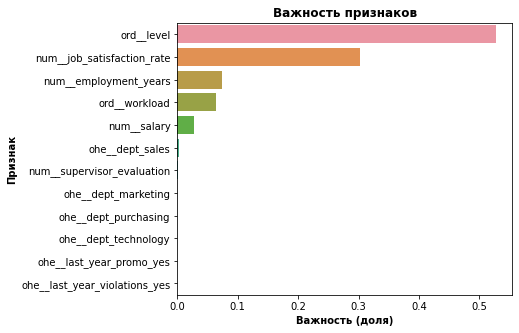

In [109]:
# визуализируем важность признаков
plt.figure(figsize=(6, 5))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importances)
ax.set_title('Важность признаков', fontsize=12, fontweight="bold")
ax.set_xlabel('Важность (доля)', fontsize=10, fontweight="bold")
ax.set_ylabel('Признак', fontsize=10, fontweight="bold")
plt.show()

Наибольшее влияние на предсказания модели оказывают должность сотрудника и уровень удовлетворенности работой. Признаки, связанные с зарплатой и нагрузкой на работе, также имеют некоторое влияние, но значительно меньше. 
Для удержания сотрудников важно уделять внимание этим аспектам и своевременно принимать меры для повышения удовлетворенности сотрудников, предоставления возможностей для карьерного роста.

DecisionTreeClassifier показал наилучшие результаты по ROC-AUC. Это может быть связано с тем, что дерево решений лучше справляется с разделением данных по признакам.
<br>В модели DecisionTreeClassifier были испытаны различные комбинации параметров, и результаты показывают, что определенные параметры (max_depth, min_samples_split и min_samples_leaf) значительно улучшили производительность модели.
<br>Использование различных методов масштабирования (например, StandardScaler, MinMaxScaler, и MaxAbsScaler) также могло повлиять на результаты. Некоторые методы масштабирования оказались более подходящими для улучшения ROC-AUC в контексте данной модели.
<br>Хотя KNeighborsClassifier показал достойные результаты, его ROC-AUC ниже по сравнению с DecisionTreeClassifier. Это может быть связано с тем, что KNeighborsClassifier может требовать больше настройки гиперпараметров (например, числа соседей) и может быть чувствителен к шуму в данных.

## Общий вывод

В ходе работы рассмотрены данные с характеристиками сотрудников одной компании. Среди них — уровень удовлетворённости сотрудника работой в компании, полученный из форм обратной связи (0 — совершенно неудовлетворён, 1 — полностью удовлетворён).
Удовлетворённость работой напрямую влияет на отток сотрудников. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Необходимо решить две задачи:
- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных компании.
- Вторая — построить модель, которая сможет на основе данных компании предсказать то, что сотрудник уволится из компании.

В ходе работы проведена предобработка данных, исследовательский  и корреляционный анализ данных. 

В результате предобработки обнаружены пропуски в датафреймах train_job и test_input. Пропуски заполнены в пайплайне в ходе решения поставленных задач.

Результаты исследовательского анализа данных:
1. Численность отделов:
- Самый многочисленный отдел: Sales.
- Второе место по численности занимает отдел Technology.
- На третьем месте отдел Purchasing.
- Самый малочисленный отдел: HR.

2. Распределение должностей:
- Наибольшее количество сотрудников работают на должности Junior.
- Наименьшее количество сотрудников — на должности Senior.

3. Уровень загруженности сотрудников:
- 30% сотрудников имеют низкий уровень загруженности.
- 50% сотрудников имеют средний уровень загруженности.
- Остальные сотрудники имеют высокий уровень загруженности.

4. Повышения и нарушения:
- 3% сотрудников были повышены за последний год.
- 14% сотрудников нарушали трудовой договор за последний год.

5. Увольнения:
- 28% сотрудников уволились из компании.

6. Стаж работы в компании:
- Средняя продолжительность работы составляет 3 года.
- Только 25% сотрудников работают более 6 лет.

7. Оценка руководителей:
- Большинство сотрудников имеют оценку руководителя 3 или 4.

8. Заработная плата:
- Самая высокая зарплата в отделе Technology.
- Самая низкая зарплата в отделе Sales.
- Средние уровни зарплаты:
    - Junior: 24200
    - Middle: 39714
    - Senior: 57292
- Минимальный разброс заработной платы наблюдается у сотрудников уровня Junior, максимальный — у Senior.

9. Удовлетворенность сотрудников:
- Самыми удовлетворенными являются специалисты уровня Middle.
- Сотрудники отдела Purchasing наиболее удовлетворены, а сотрудники отдела Marketing — наименее удовлетворены.
- Наиболее удовлетворены сотрудники, работающие в компании 7-9 лет, тогда как самые неудовлетворенные — те, кто работает в компании 1 год.

Для решения первой задачи были рассмотрены две модели: DecisionTreeRegressor и LinearRegression.

Создан пайплайн для предобработки данных, включающий:
- заполнение пропусков,
- кодирование категориальных признаков,
- масштабирование числовых признаков.  

Подбор гиперпараметров выполнялся с использованием RandomizedSearchCV, кросс-валидации и пользовательской метрики SMAPE.
 
Лучшей моделью, прогнозирующей целевой признак, стала DecisionTreeRegressor, с метрикой SMAPE, равной 13.83 на тестовой выборке.

Согласно результатам моделирования, оценка качества работы сотрудника (supervisor_evaluation) оказывает наибольшее влияние на уровень удовлетворённости сотрудника. Это указывает на то, что положительная оценка со стороны руководителя может существенно повысить удовлетворённость сотрудников, что, в свою очередь, может повлиять на их мотивацию и решение остаться в компании. Обратная связь и признание заслуг сотрудника, возможно, являются ключевыми факторами, которые способствуют созданию положительного опыта работы и удовлетворённости сотрудников в компании.

На основе анализа данных можно сделать вывод, что сотрудники с определёнными характеристиками более склонны к увольнению. Чаще других увольняются сотрудники со следующими параметрами:
- Стаж работы в компании: 1-3 года. Сотрудники с небольшим опытом работы в компании могут чувствовать меньшую привязанность или удовлетворённость текущими условиями труда, что делает их более склонными к смене работы.
- Оценка качества работы руководителем: на уровне 1-3. Низкие оценки от руководителей могут указывать на недовольство руководства результатами работы сотрудников, что может демотивировать сотрудников и подтолкнуть их к уходу.
- Заработная плата: до 30,000. Низкая зарплата может быть одной из причин увольнения, особенно если у сотрудников есть возможность найти более высокооплачиваемую работу.
- Должность: junior. Сотрудники на младших должностях часто рассматривают свои текущие позиции как стартовые и, возможно, ищут возможности для карьерного роста за пределами компании.
- Уровень загруженности: низкий. Сотрудники с низким уровнем загруженности также имеют тенденцию к более высокой частоте увольнений. Это может быть связано с недостатком интересных задач и вызовов, что приводит к желанию искать более стимулирующую работу.
- Уровень удовлетворённости: до 0.5. Низкий уровень удовлетворённости может свидетельствовать о неудовлетворённости рабочими условиями, корпоративной культурой, зарплатой или другими аспектами работы, что побуждает сотрудников искать работу в более благоприятной среде.
- Отсутствие повышения в прошлом году: сотрудники, которые не получали повышение, могут чувствовать, что их усилия не были признаны, что снижает их мотивацию и удовлетворённость работой.
- Нарушение трудового договора за последний год: это может отражать проблемы с дисциплиной или конфликты, которые в итоге приводят к увольнению.

Эти факторы указывают на определённый профиль сотрудников, которые чаще всего принимают решение покинуть компанию. Понимание этих характеристик поможет разработать стратегию удержания персонала, ориентированную на улучшение условий труда и повышения удовлетворённости сотрудников.

Для решения второй задачи были рассмотрены четыре модели: DecisionTreeClassifier и LogisticRegression, KNeighborsClassifier и SVC.

Создан пайплайн для предобработки данных, включающий:
- заполнение пропусков,
- кодирование категориальных признаков,
- масштабирование числовых признаков.
Подбор гиперпараметров выполнялся с использованием RandomizedSearchCV, кросс-валидации и метрики ROC-AUC.

Лучшей моделью, прогнозирующей целевой признак, стала DecisionTreeClassifier, с метрикой ROC-AUC равной 0.92 на тестовой выборке.

Наибольшее влияние на предсказания модели оказывают должность сотрудника и уровень удовлетворенности работой. Признаки, связанные с зарплатой и нагрузкой на работе, также имеют некоторое влияние, но значительно меньше. 
Для удержания сотрудников важно уделять внимание этим аспектам и своевременно принимать меры для повышения удовлетворенности сотрудников, предоставления возможностей для карьерного роста.